In this notebook i'll be training a DeepOnet to learn the results from the simulations done for the damped pendulum in the `simulations` notebook.

In [2]:
import os
# os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=60" # Example for 4 cores

import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx

import optax
import h5py

import matplotlib.pyplot as plt

# Loading the data

Let's first load the HDF5 arrays into memory and Jax.

In [3]:
with h5py.File("../../outputs/damped_pendulum_simulations.h5", "r") as f:
    
    print(f.keys())
    parameters = jnp.array(f["parameters"])
    simulations = jnp.array(f["simulations"][:, :, 0])
    time = jnp.array(f["time"]).reshape(-1, 1)
    

<KeysViewHDF5 ['parameters', 'simulations', 'time']>


In [3]:
parameters.shape, simulations.shape, time.shape

((390625, 4), (390625, 100), (100, 1))

# Defining the network

In [4]:
from typing import Callable

class DeepOnet(eqx.Module):
    branch_net: eqx.nn.MLP
    trunk_net: eqx.nn.MLP
    bias: jax.Array

    def __init__(
        self, 
        in_branch: int,
        in_trunk: int,
        width: int,
        depth: int,
        interact: int,
        activation: Callable,
        *,
        key
    ):
        """
        Simplified deeponet using twin hidden architectures
        """

        b_key, t_key = jax.random.split(key)

        self.branch_net = eqx.nn.MLP(
            in_branch,
            interact,
            width,
            depth,
            activation,
            key=b_key
        )

        self.trunk_net = eqx.nn.MLP(
            in_trunk,
            interact,
            width,
            depth,
            activation,
            final_activation=activation,
            key=b_key
        )

        self.bias = jnp.zeros((1,))

    
    def __call__(self, x_branch, x_trunk):
        """
        x_branch.shape = (in_size_branch,)
        x_trunk.shape = (1,)

        return shape: "scalar"
        """

        branch_out = self.branch_net(x_branch)
        trunk_out = self.trunk_net(x_trunk)

        inner_product = jnp.sum(branch_out*trunk_out, keepdims=True)

        return (inner_product + self.bias)[0]
        
    

In [5]:
deeponet = DeepOnet(
    4,
    1,
    64,
    6,
    32,
    activation=jax.nn.relu,
    key=jax.random.key(463)
)

# Training the network

In [6]:
outputs = jax.vmap(jax.vmap(deeponet, in_axes=(None, 0)), in_axes=(0, None))(parameters, time)

2025-08-10 23:29:13.529682: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-08-10 23:29:13.887374: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


In [7]:
def loss_fn(model):
    outputs = jax.vmap(jax.vmap(model, in_axes=(None, 0)), in_axes=(0, None))(parameters, time)

    mse = jnp.mean(jnp.square(outputs - simulations))

    return mse

@eqx.filter_jit
def update(opt_state, model):
    
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model)
    updates, new_state = optmizer.update(grad, opt_state, model)
    new_model = eqx.apply_updates(model, updates)

    return loss, new_model, new_state

In [8]:
deeponet = DeepOnet(
    4,
    1,
    64,
    6,
    32,
    activation=jax.nn.relu,
    key=jax.random.key(463)
)

losses = []

In [53]:
from copy import deepcopy

optmizer = optax.adam(0.001)
opt_state = optmizer.init(eqx.filter(deeponet, eqx.is_array))

min_loss = min(losses) if losses else 1_000_000

for epoch in range(100_000):

    loss, deeponet, opt_state = update(opt_state, deeponet)

    losses.append(loss)

    if epoch % 1000 == 0:
        print(f"{epoch = } | {loss = }")

    if loss <= min_loss:
        print(f"Best model  at step: {len(losses)} | {loss = }")
        best_model = deepcopy(deeponet)
        min_loss = loss

epoch = 0 | loss = Array(0.00046392, dtype=float32)
epoch = 100 | loss = Array(0.00048798, dtype=float32)
epoch = 200 | loss = Array(0.0003886, dtype=float32)
epoch = 300 | loss = Array(0.00037113, dtype=float32)
Best model  at step: 127678 | loss = Array(0.00036508, dtype=float32)
Best model  at step: 127680 | loss = Array(0.00036506, dtype=float32)
Best model  at step: 127681 | loss = Array(0.00036436, dtype=float32)
Best model  at step: 127684 | loss = Array(0.00036427, dtype=float32)
Best model  at step: 127687 | loss = Array(0.00036406, dtype=float32)
epoch = 400 | loss = Array(0.00036375, dtype=float32)
Best model  at step: 127692 | loss = Array(0.00036375, dtype=float32)
Best model  at step: 127693 | loss = Array(0.00036343, dtype=float32)
Best model  at step: 127695 | loss = Array(0.00036339, dtype=float32)
Best model  at step: 127698 | loss = Array(0.00036305, dtype=float32)
Best model  at step: 127706 | loss = Array(0.00036278, dtype=float32)
Best model  at step: 127715 | los

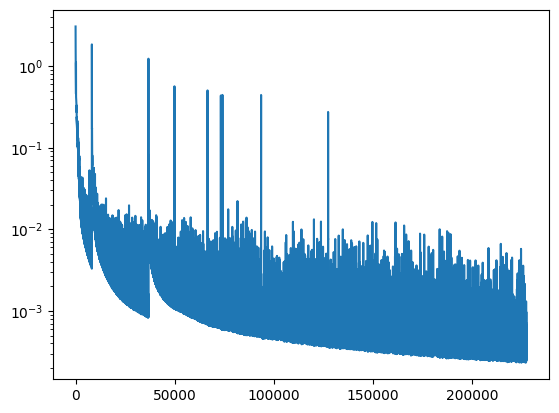

In [54]:
plt.plot(losses)
plt.yscale("log")

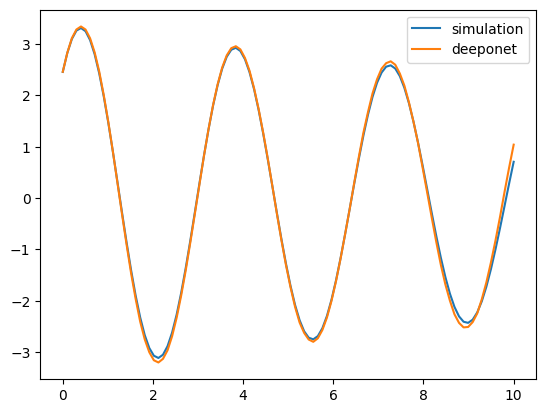

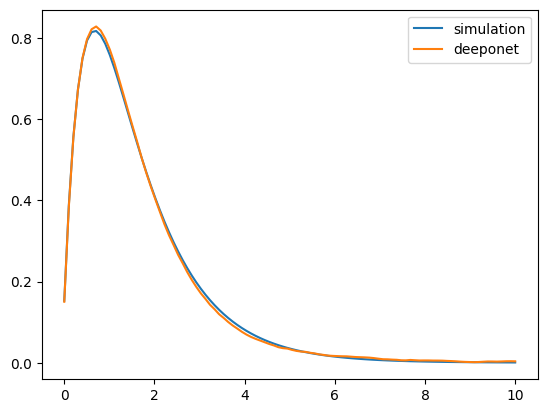

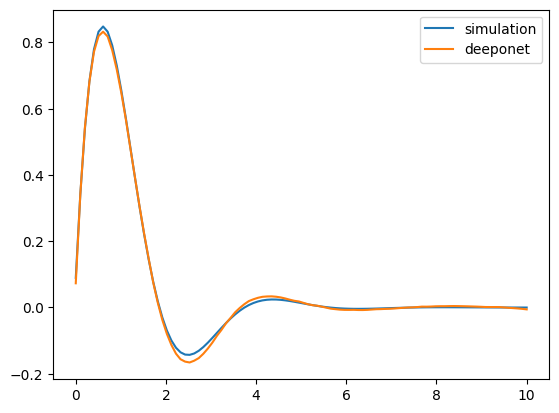

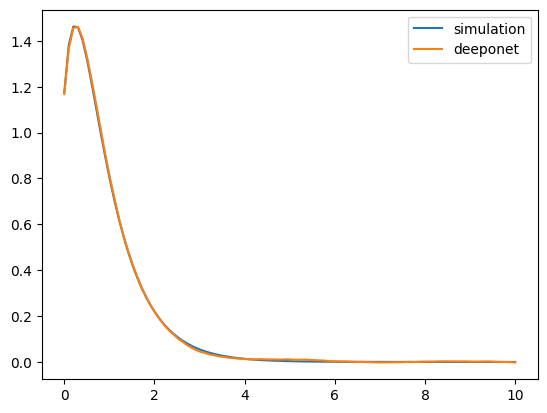

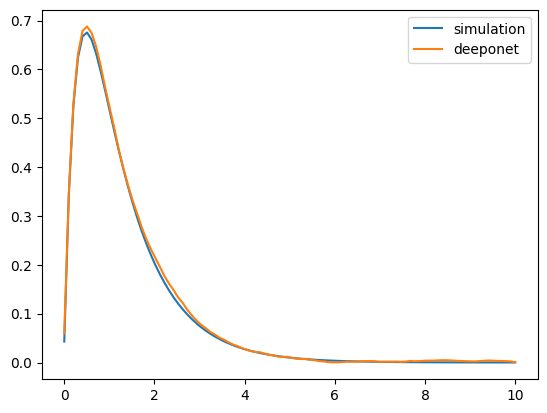

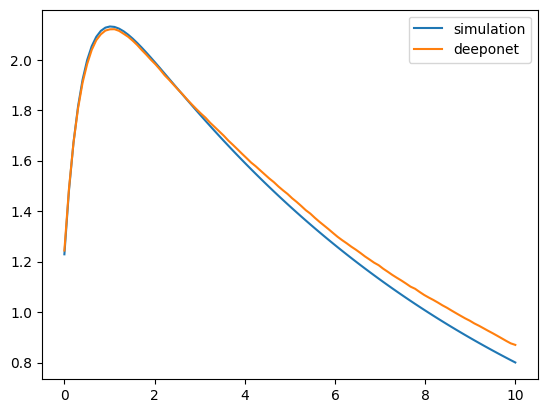

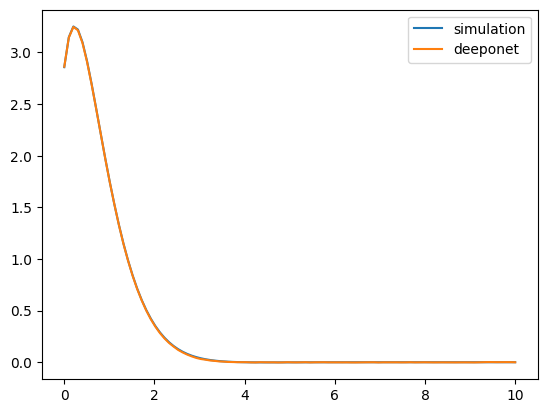

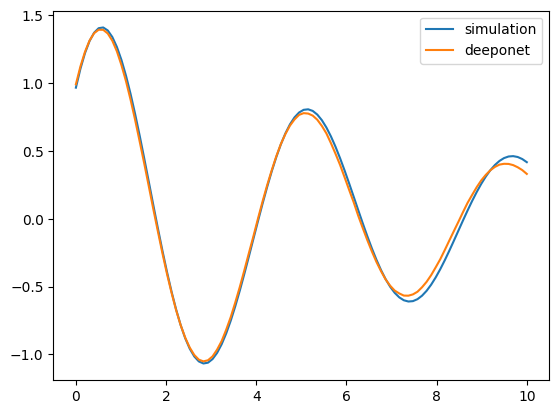

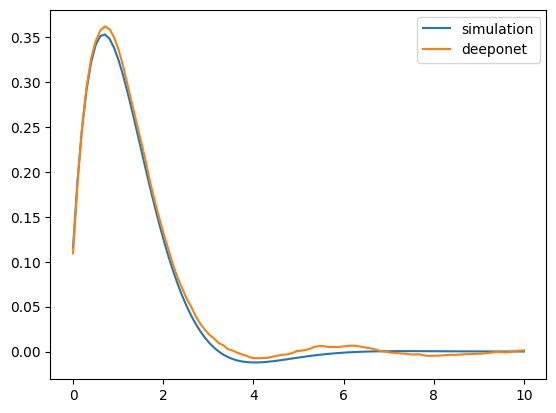

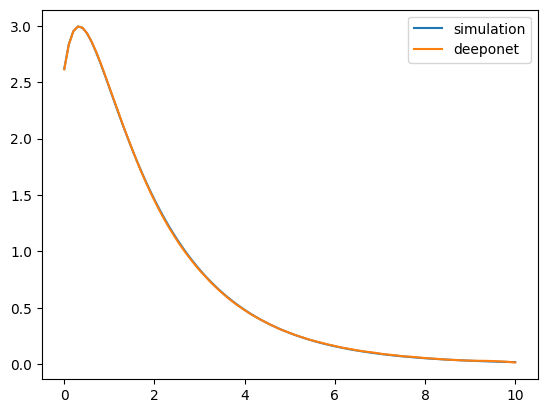

In [33]:
from scipy.integrate import odeint
from random import randint

def damped_oscillator_scipy(y, t, beta, k):
    x, v = y
    dxdt = v
    dvdt = -beta * v - k * x
    return [dxdt, dvdt]

def simulate(args):

    k, beta, *initial_cond = args
    ts = np.linspace(0, 10, 100)  
    
    solution = odeint(damped_oscillator_scipy, initial_cond, ts, args=(beta, k))

    return solution

ts = np.linspace(0, 10, 100) 

for _ in range(10):
    args = np.random.uniform(0.0, 5.0, size=(4,)).tolist()
    
    
    
    x, v = simulate(args).T
    
    # idx = randint(0, parameters.shape[0])
    # args = parameters[idx].tolist()
    
    x_deeponet = jax.vmap(best_model, in_axes=(None, 0))(jnp.array(args), time)
    
    plt.plot(ts, x, label="simulation")
    plt.plot(ts, x_deeponet, label="deeponet")
    
    plt.legend()

    plt.show()

It looks like it has properly learned the operator, it can get better but let's move on for now! Let's save this model and move foward to the notebook on the inverse problem using it!

# Saving result model

In [59]:
eqx.tree_serialise_leaves("best_model.eqx", best_model)

Let's test if the model was properly saved.

In [6]:
jax.config.update("jax_platform_name", "cpu")

best_model_reloading = DeepOnet(
    4,
    1,
    64,
    6,
    32,
    activation=jax.nn.relu,
    key=jax.random.key(463)
)

best_model_reloading = eqx.tree_deserialise_leaves("best_model.eqx", best_model_reloading)

2025-09-13 16:36:18.916355: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-09-13 16:36:19.455317: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


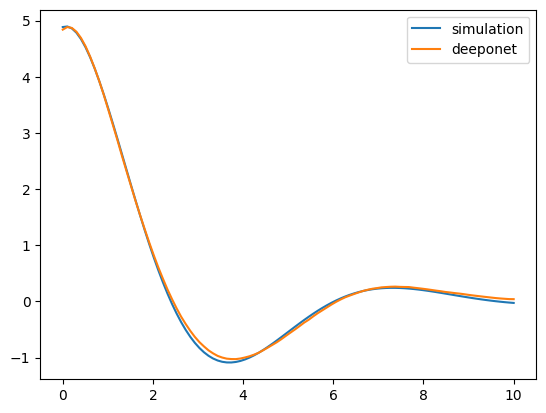

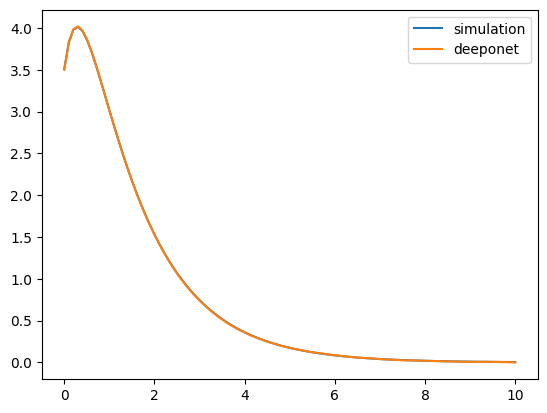

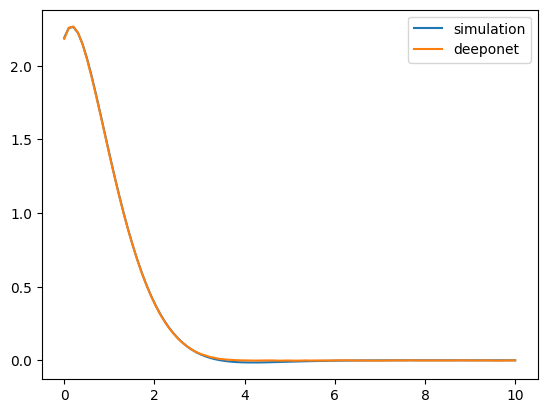

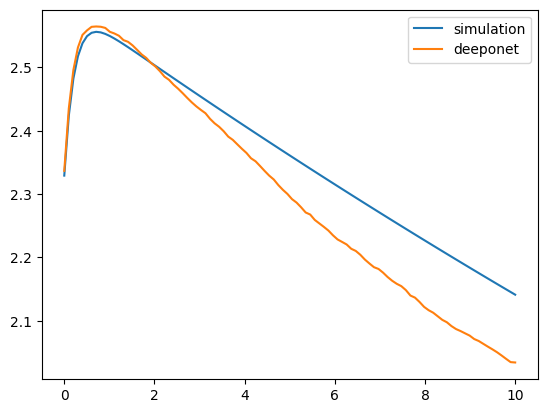

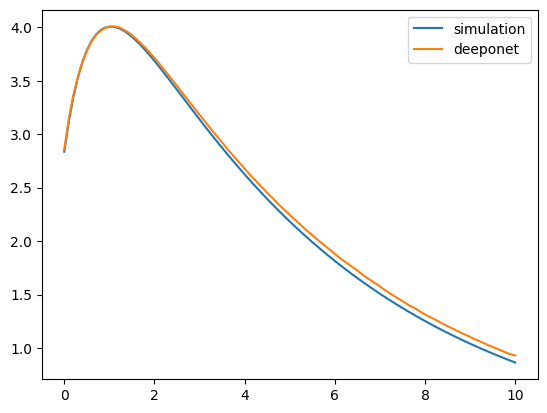

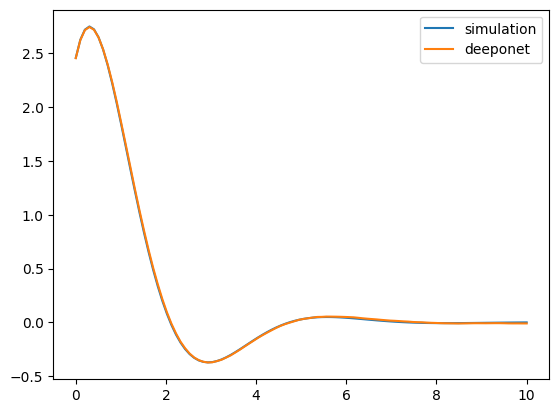

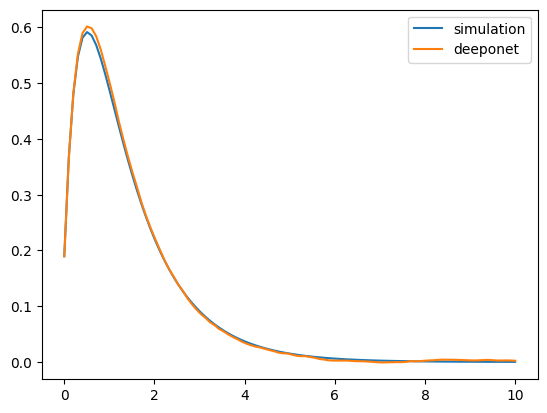

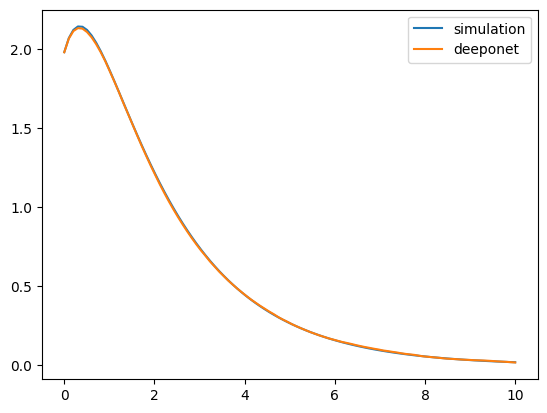

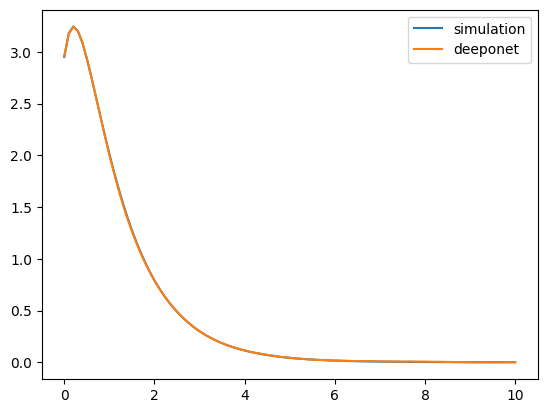

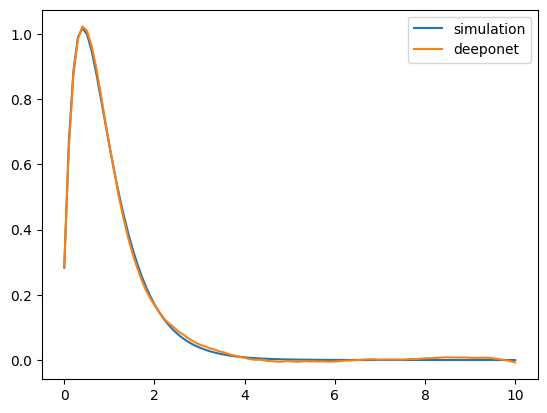

In [7]:
for _ in range(10):
    args = np.random.uniform(0.0, 5.0, size=(4,)).tolist()
    
    
    x, v = simulate(args).T

    x_deeponet = jax.vmap(best_model_reloading, in_axes=(None, 0))(jnp.array(args), time)
    
    plt.plot(ts, x, label="simulation")
    plt.plot(ts, x_deeponet, label="deeponet")
    
    plt.legend()

    plt.show()

(np.longdouble('2.0678008646604980704e-05'),
 np.longdouble('0.0033141308850247658962'),
 np.longdouble('0.003649821723256828454'),
 np.longdouble('0.014634851052602427374'))

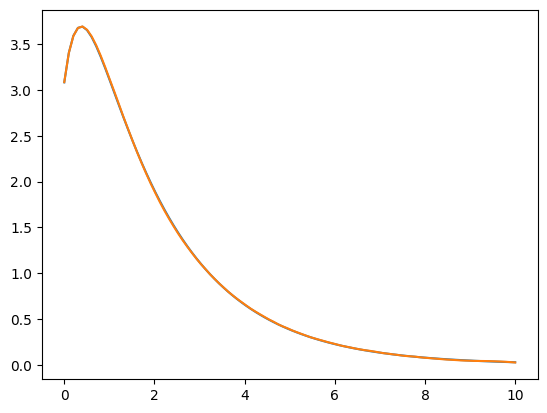

In [8]:
args = np.random.uniform(0.0, 5.0, size=(4,)).tolist()



x, v = simulate(args).T

# idx = randint(0, parameters.shape[0])
# args = parameters[idx].tolist()

x_deeponet = jax.vmap(best_model_reloading, in_axes=(None, 0))(jnp.array(args), time)

x_deeponet = np.float128(x_deeponet)
x = np.float128(x)

x_deeponet.shape
mse = np.mean((x_deeponet - x)**2)
mae = np.mean(np.abs(x_deeponet - x))
smare = np.mean(np.abs(x_deeponet - x)/(abs(x_deeponet) + abs(x))/2)
mare = np.mean(np.abs((x_deeponet - x)/x))

plt.plot(ts, x, label="simulation")
plt.plot(ts, x_deeponet, label="deeponet")

mse, mae, smare, mare

# Testing systematically

In [12]:
def get_test():

    # print(f" Running sim {i}\n")
    args = np.random.uniform(0.0, 5.0, size=(4,)).tolist()
    x, v = simulate(args).T
    
    x_deeponet = jax.vmap(best_model_reloading, in_axes=(None, 0))(jnp.array(args), time)
    

    mse = np.mean((x_deeponet - x)**2)
    mae = np.mean(np.abs(x_deeponet - x))
    smare = np.mean(np.abs(x_deeponet - x)/(abs(x_deeponet) + abs(x))/2)
    mare = np.mean(np.abs((x_deeponet - x)/x))

    return mse, mae, smare, mare



In [13]:
args = [get_test() for i in range(4000)]
args = jnp.array(args)

(-1.0, 2.0)

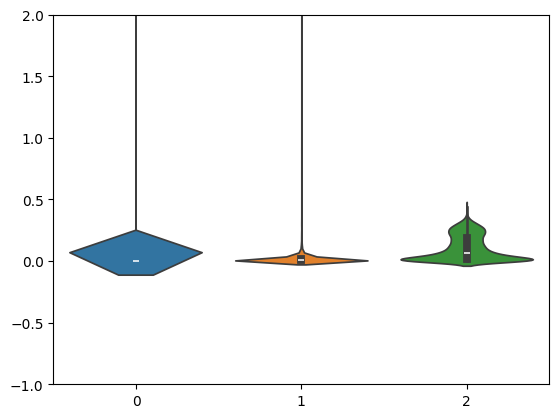

In [27]:
import seaborn as sns

ax = sns.violinplot(args[:, 0:3])

ax.set_ylim(-1, 2)

In [28]:
args.mean(axis=0)

Array([1.04162423e-02, 1.82737708e-02, 1.04670845e-01, 1.26562048e+03],      dtype=float32)

In [29]:
args.std(axis=0)

Array([2.998953e-01, 7.440496e-02, 9.998823e-02, 1.658379e+04], dtype=float32)

Let's move on to the inversion problem!